In [504]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display
from skimage.transform import hough_line, hough_line_peaks

In [505]:
def Pi(p:np.ndarray | list) -> np.ndarray:
    """convert from homogeneous coordinates to inhomogeneous coordinates

    subtract one coordinate"""
    if isinstance(p, np.ndarray):
        return p[:-1]/p[-1]
    elif isinstance(p, list):
        return [Pi(np.array(p_)) for p_ in p]

def PiInv(p:np.ndarray | list) -> np.ndarray:
    """convert from inhomogeneous coordinates to homogeneous coordinates

    add one coordinate with value 1"""
    if isinstance(p, np.ndarray):
        return np.vstack((p, np.ones(p.shape[1])))
    elif isinstance(p, list):
        return [PiInv(np.array(p_)) for p_ in p]

# Hough Transform

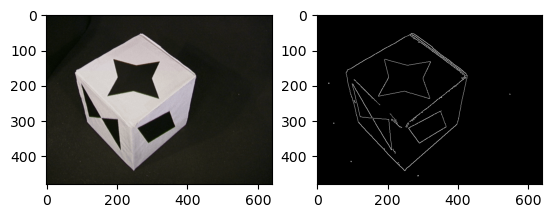

In [506]:
# 7.1
im = cv2.imread('data/week06_data/Box3.bmp')[:,:,::-1]
# im = im.astype(float)/255
edges = cv2.Canny(im, 50, 200)
fig, ax = plt.subplots(1,2)
ax[0].imshow(im, cmap='gray');
ax[1].imshow(edges, cmap='gray');

In [507]:
# 7.2
hspace, angles, dists = hough_line(edges)

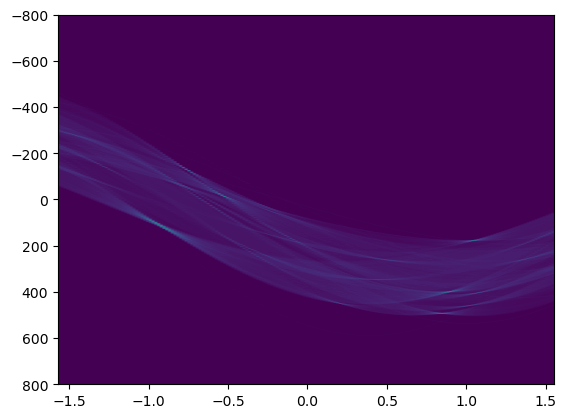

In [508]:
# 7.3
extent = [angles[0], angles[-1], dists[-1], dists[0]] 
plt.imshow(hspace, extent=extent, aspect='auto')

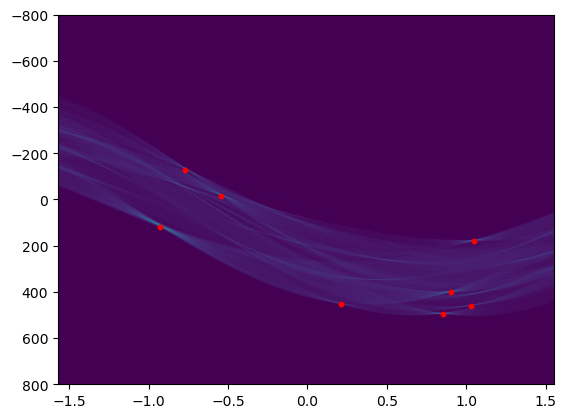

In [509]:
# 7.4
n = 8
extH, extAngles, extDists = hough_line_peaks(hspace, angles, dists, num_peaks=n)
plt.scatter(extAngles, extDists, color='red', s=10)
plt.imshow(hspace, extent=extent, aspect='auto')

In [510]:
def DrawLine(l, shape, allow_negative=False):
    """Checks where the line intersects the four sides of the image and finds the two intersections that are within the frame""" 
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if allow_negative:
            return q
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
            
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    if (len(P)==0):
        print("Line is completely outside image")
    plt.plot(*np.array(P).T)

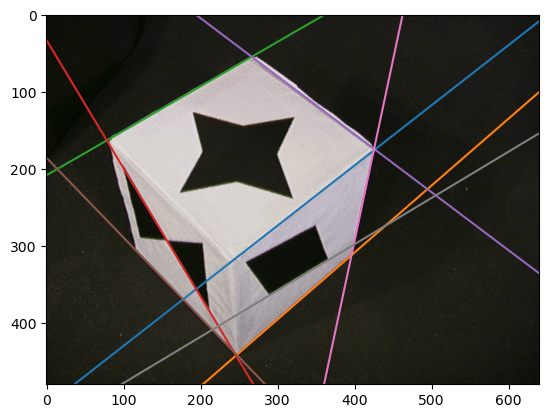

In [511]:
# 7.5
# lines should be input in r, θ representation
for angle, dist in zip(extAngles, extDists):
    l = np.array([np.cos(angle), np.sin(angle), -dist])
    DrawLine(l, edges.shape)
plt.imshow(im, cmap='gray');

De linjer der bliver fundet er afhængige af n valgt ovenover og Canny detectoren

# RANSAC

In [512]:
def test_points(n_in, n_out):
    """
    generate test points
    n_in: number of inliers
    n_out: number of outliers"""
    a = (np.random.rand(n_in)-.5)*10
    b = np.vstack((a, a*.5+np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T

In [513]:
# 7.6 
def estimate_line(point0, point1):
    """Estimates a line in homogeneous coordinates from two points using the cross product"""
    return np.cross(point0, point1)

points = test_points(25, 15)
points = PiInv(points)
# test
l = estimate_line(points[:,0], points[:,1])
l

array([ 3.3376217 , -6.26628504, -0.65367191])

In [514]:
def scale_line(l):
    """Scales a line so that a^2 + b^2 = 1"""
    return l/np.sqrt(l[0]**2 + l[1]**2)
# test
l = scale_line(l)
a, b, c = l[0], l[1], l[2]
a**2 + b**2

1.0

In [515]:
# 7.7
def inliers(line, points, threshold):
    """Returns the indices of the points that are within the threshold of the line
    if points are in inhomogeneous coordinates, they are converted to homogeneous coordinates automatically"""
    if points.shape[0] != 3:
        points = PiInv(points)
    return np.where(np.abs(line @ points) < threshold)[0]

# test
inlier_points = inliers(l, points, .5)
inlier_points

array([ 0,  1,  2,  3,  9, 10, 11, 12, 13, 14, 16, 19, 20, 21, 22, 23, 26,
       27, 28, 31, 32, 33, 34, 36, 38, 39], dtype=int64)

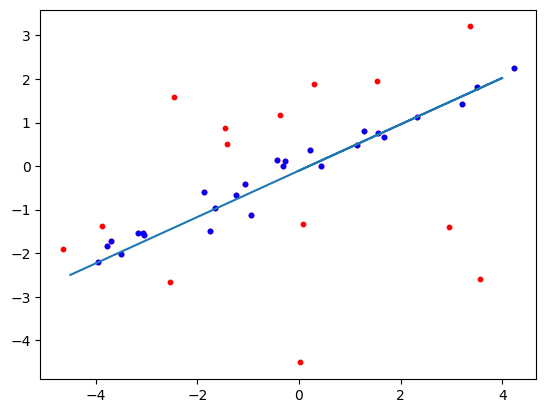

In [516]:
plt.scatter(points[0], points[1], color='red', s=10)
plt.scatter(points[0][inlier_points], points[1][inlier_points], color='blue', s=10)
# note that the DrawLine function is not able to draw lines that go to a negative coordinate
DrawLine(l, (-1.5,5), allow_negative=True)

In [517]:
# 7.8
def consensus(line, points, threshold):
    """Returns the number of inliers for a given line and a set of points"""
    return len(inliers(line, points, threshold))

In [518]:
# 7.9
def randomly_draw_two_points(points):
    """Draws two random points from a set of points"""
    # replace must be false, to avoid fitting a line through the same point twice
    return np.random.choice(points.shape[1], 2, replace=False)

In [519]:
def pca_line(x):
    """get a homogeneous line along the first principal component"""
    # assumes x is a (2 x n) array of points     
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(- (l @ x.mean(1)))
    return l

In [520]:
# 7.10
def RANSAC(points, threshold, max_iter, lstsq_fit=True, adaptive=True, p=0.99):
    """Runs the RANSAC algorithm to estimate a line from a set of points
    
    Parameters
    ----------
    points: array of shape (2, n)
        The points from which to estimate a line
    threshold: float
        The threshold for the distance of a point to the line
    min_points: int
        The minimum number of points that need to be inliers for the algorithm to stop
    max_iter: int
        The maximum number of iterations the algorithm will run
    lstsq_fit: bool
        If True, the final line will be estimated using a least squares fit to the inliers of the best model
    adaptive: bool
        If True, the number of iterations will be adapted to the probability that a random sample is free of outliers
    p: float
        The probability that a random sample is free of outliers
        only relevant if adaptive is True
    
    Returns
    -------
    best_line: array of shape (3,)
        The line that was estimated by the RANSAC algorithm
    best_inliers: array of shape (n,)
        The indices of the points that were inliers of the best line
    """
    n = 2 # since we sample two points to fit a line
    best_line = None
    best_consensus = 0
    N_hat = max_iter
    i = 0
    while (i < max_iter and i < N_hat):
        p0, p1 = randomly_draw_two_points(points)
        line = estimate_line(points[:,p0], points[:,p1])
        line = scale_line(line)
        cons = consensus(line, points, threshold)
        if cons > best_consensus:
            best_consensus = cons
            best_line = line
        if adaptive:
            m = points.shape[1]
            s = best_consensus
            e_hat = 1 - s/m
            N_hat = np.log(1-p)/np.log((1-(1-e_hat)**n))
        i += 1
    # final step: re-estimate line using all inliers of best mode
    best_inliers = inliers(best_line, points, threshold)
    if lstsq_fit:
        x = points[:,best_inliers] # 7.12
        best_line = pca_line(x[:2]) # 7.12 fit a lstsq line to the inliers
    best_line = scale_line(best_line)
    return best_line, best_inliers

In [521]:
# 7.11
# 0.5 seems to be good threshold
l, found_inliers = RANSAC(points, .5, 100, lstsq_fit=True, adaptive=True, p=0.99)
l, found_inliers

(array([ 0.45589779, -0.89003214, -0.01571969]),
 array([ 0,  1,  2,  3,  9, 10, 11, 12, 13, 14, 16, 19, 20, 21, 22, 23, 26,
        27, 28, 31, 32, 33, 34, 36, 38, 39], dtype=int64))

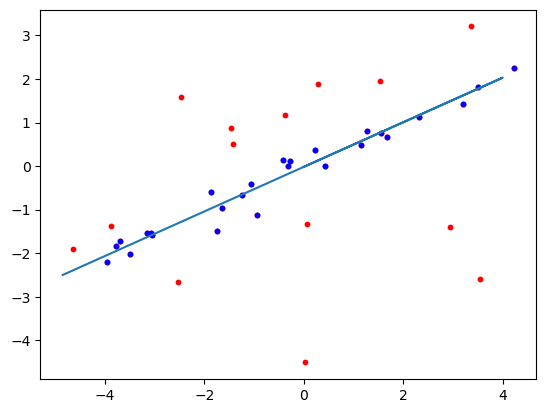

In [522]:
plt.scatter(points[0], points[1], color='red', s=10)
plt.scatter(points[0][found_inliers], points[1][found_inliers], color='blue', s=10)
# note that the DrawLine function is not able to draw lines that go to a negative coordinate
DrawLine(l, (-1.5,5), allow_negative=True)